In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.discriminator = nn.Sequential(
        nn.Linear(img_dim, 128), #input
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1), #output
        nn.Sigmoid(), #softmax
    )
  def forward(self, x):
    return self.discriminator(x
    )

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.generator = nn.Sequential(
        nn.Linear(z_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, img_dim), # output 28*28 image
        nn.Tanh() #Why Tanh (-1, 1)
    )

  def forward(self, x):
    return self.generator(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

In [ ]:
#initializing variables
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

#noise
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

#transformations
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

## Load Data

In [ ]:
#load dataset
data = datasets.MNIST(root="dataset/", transform=transforms, download=True)
#data = data.train_data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 57015433.67it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2067020.92it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1538431.56it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2671508.73it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
##getting images of 9
print(sum(data.targets == 9))
data_9 = data.data[data.targets == 9]
data_9.shape

tensor(5949)


torch.Size([5949, 28, 28])

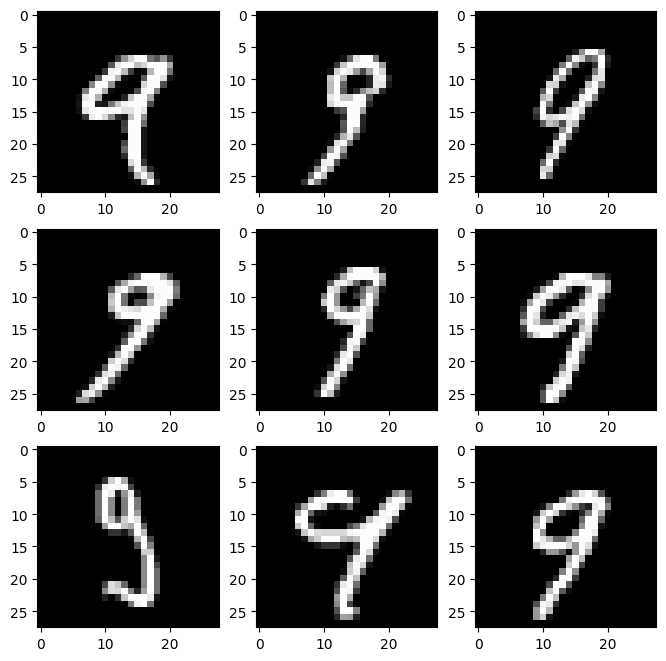

In [ ]:
import matplotlib.pyplot as plt

sample = data_9[:9,:,:]
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, img in enumerate(sample):
    ax.ravel()[i].imshow(img, cmap='gray')
    #ax.ravel()[i].set_axis_off()
plt.show()

## Step2:

In [ ]:
loader = DataLoader(dataset = data, batch_size = batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
loss = nn.BCELoss()

# #TensorBoard
# writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
# writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

In [ ]:

for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ### Train Discriminator
    ##Generate noise
    noise = torch.randn(batch_size, z_dim).to(device)
    fake = gen(noise)

    ## Real image loss
    disc_real = disc(real).view(-1)
    loss_disc_real = loss(disc_real, torch.ones_like(disc_real))

    ## Fake image loss
    disc_fake = disc(fake).view(-1)
    loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))

    ## average loss
    loss_disc = (loss_disc_real + loss_disc_fake) / 2

    ## Discriminator backward pass
    disc.zero_grad() #set gradient
    loss_disc.backward(retain_graph=True) #retain_graph? #calculate gradient
    opt_disc.step() #update weights

    ###----------------------------------
    ### Train Generator
    output = disc(fake).view(-1) #why we do this thing again
    loss_gen = loss(output, torch.ones_like(output)) #? disc tells fake(0) but we need it be real(1)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    ##results
    if batch_idx == 0:
      print(f"Epoch [{epoch}/ {num_epochs}]",
            f"LossD : {loss_disc:.4f}, LossG : {loss_gen:.4f}", sep='\n')
      ##Store results
      with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
        data = real.reshape(-1, 1, 28, 28)
        img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        img_grid_real = torchvision.utils.make_grid(data, normalize=True)

        #visualize img_grid
        plt.imshow(img_grid_fake.permute(1, 2, 0))
        plt.imshow(img_grid_real.permute(1, 2, 0))
        plt.show()
